In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch import optim

print('torch.cuda.is_available():', torch.cuda.is_available())
print('torch.cuda.device_count():', torch.cuda.device_count())

torch.cuda.is_available(): True
torch.cuda.device_count(): 1


In [18]:
import random
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import utils
import models
import fl_utils as fl

In [5]:
# Set a seed value
seed = 42 
os.environ['PYTHONHASHSEED']=str(seed)
torch.manual_seed(0)
random.seed(seed)
np.random.seed(seed)

In [6]:
# Allocate gpu memory in advance.
# utils.allocate_gpu_memory()

In [7]:
save_interval = 10
save_dir = './output/federated_single_class'
os.makedirs(save_dir, exist_ok=True)

In [8]:
batch_size = 64
num_workers = 2

data_dir = './data/'
train_dir = os.path.join(data_dir, 'train_sub')
valid_dir = os.path.join(data_dir, 'valid_sub')

# For testing the global model.
transform = transforms.Compose([transforms.Resize((96, 96)), transforms.ToTensor()])
valid_data = ImageFolder(valid_dir, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
num_classes = len(valid_data.classes)

In [9]:
client_list = sorted(os.listdir(train_dir))
print(client_list)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glob_model = models.CNNModel(num_classes)
glob_model.to(device)
glob_w = glob_model.state_dict()

In [10]:
num_rounds = 100
num_local_epochs = 3
batch_size = 64
num_workers = 2

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
_, performance_log = utils.get_performance_loggers(metric_keys)

for round_no in range(num_rounds):
    
    utils.print_separator(text='Round: {}'.format(round_no))
    client_updates = dict()
    
    # Federated training.
    for label_idx, client in enumerate(client_list):
        print('client:', client)
        client_data_dir = os.path.join(train_dir, client)
        client_dataset = fl.SingleClassClientData(img_dir=client_data_dir, label=label_idx, transform=transform)
        client_data_loader = torch.utils.data.DataLoader(client_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        client_update = fl.local_update(models.CNNModel(num_classes), glob_w, client_data_loader, num_local_epochs)
        for key in ['local_w', 'num_samples', 'loss', 'acc']:
            client_updates.setdefault(key, list()).append(client_update[key])
    
    # Model aggregation.
    glob_w = fl.weighted_averaging(client_updates['local_w'], client_updates['num_samples'])
    glob_model.load_state_dict(glob_w)
    
    # Average training performance.
    performance_log['train_loss'].append(sum(client_updates['loss'])/len(client_updates['loss']))
    performance_log['train_acc'].append(sum(client_updates['acc'])/len(client_updates['acc']))
    
    # Validate the global model.
    valid_loss, valid_acc = fl.evaluate_model(glob_model, valid_loader)
    performance_log['valid_loss'].append(valid_loss)
    performance_log['valid_acc'].append(valid_acc)
    
    utils.print_result(performance_log)
    
    if  (round_no + 1) % save_interval == 0:
        torch.save(glob_model.state_dict(), os.path.join(save_dir, 'round_{}_loss_{:.2f}_acc_{:.2f}.pth'.format(round_no+1, performance_log['valid_loss'][-1], performance_log['valid_acc'][-1])))
    
utils.save_pickle(os.path.join(save_dir, 'performance_log.pickle'), performance_log)


 ==================== Round: 0 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.1486          acc:    1.0000
valid     -              loss :    23.1096          acc:    0.1170


 ==================== Round: 1 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.0807          acc:    1.0000
valid     

client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    1.0827          acc:    0.9167
valid     -              loss :    7.9010          acc:    0.1290


 ==================== Round: 16 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    1.4943          acc:    0.9167
valid     -              loss :    5.7527          acc:    0.1290


 ==================== Round: 17 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
clien

client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    1.4712          acc:    0.9167
valid     -              loss :    7.1800          acc:    0.1290


 ==================== Round: 32 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    1.4824          acc:    0.9167
valid     -              loss :    7.4019          acc:    0.1290


 ==================== R

client: Tomato___healthy
train     -              loss :    0.8740          acc:    0.9167
valid     -              loss :    5.7315          acc:    0.1290


 ==================== Round: 47 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.8865          acc:    0.9167
valid     -              loss :    5.5953          acc:    0.1290


 ==================== Round: 48 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: 

client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    1.1575          acc:    0.9167
valid     -              loss :    6.3256          acc:    0.1290


 ==================== Round: 63 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.9934          acc:    0.9167
valid     -              loss :    6.7201          acc:    0.1290


 ==================== Round: 64 =================

client: Tomato___healthy
train     -              loss :    0.8205          acc:    0.9167
valid     -              loss :    5.7225          acc:    0.1290


 ==================== Round: 78 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.8673          acc:    0.9167
valid     -              loss :    5.7981          acc:    0.1290


 ==================== Round: 79 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: 

client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.8037          acc:    0.9167
valid     -              loss :    5.6969          acc:    0.1290


 ==================== Round: 94 ====================

client: Apple___Apple_scab
client: Apple___Black_rot
client: Apple___healthy
client: Corn___Common_rust
client: Corn___Northern_Leaf_Blight
client: Corn___healthy
client: Grape___Black_rot
client: Grape___Esca_(Black_Measles)
client: Grape___healthy
client: Tomato___Early_blight
client: Tomato___Septoria_leaf_spot
client: Tomato___healthy
train     -              loss :    0.7354          acc:    0.9167
valid     -              loss :    5.9901          acc:    0.1290


 ==================== Round: 95 =================

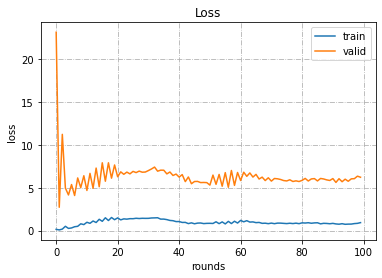

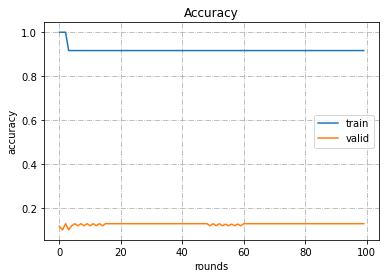

In [11]:
# Plot training history.
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
utils.save_history_plot(performance_log, loss_plot_config)

acc_plot_config = utils.ACC_PLOT_CONFIG.copy()
acc_plot_config['save_dir'] = os.path.join(save_dir, 'accuracy.png')
acc_plot_config['show_img'] = True
utils.save_history_plot(performance_log, acc_plot_config)

In [15]:
# Reload model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glob_model = models.CNNModel(num_classes=num_classes)
glob_model.to(device)
glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'round_100_loss_6.22_acc_0.13.pth')))

performance_log = utils.load_pickle(os.path.join(save_dir, 'performance_log.pickle'))

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
performance_dict, _ = utils.get_performance_loggers(metric_keys)

criterion = nn.CrossEntropyLoss()
# Validation.
global_model.eval()
with torch.no_grad():
    for step, data in enumerate(tqdm(valid_loader)):
        x_batch, y_batch = data[0].to(device), data[1].to(device)
        _, y_pred = global_model(x_batch)
        loss = criterion(y_pred, y_batch)
        performance_dict['valid_loss'].update_state(loss.item())
        performance_dict['valid_acc'].update_state(utils.compute_accuracy(y_batch, y_pred))
    
    print('valid_loss:', performance_dict['valid_loss'].result())
    print('valid_acc:', performance_dict['valid_acc'].result())

100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 17.47it/s]

valid_loss: 6.217113733291626
valid_acc: 0.12899709302325582


In [34]:
dataiter = iter(valid_loader)

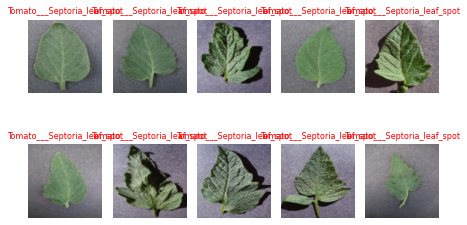

In [74]:
with torch.no_grad():
    data = dataiter.next()
    x_batch, y_batch = data[0].to(device), data[1].to(device)
    _, y_pred = glob_model(x_batch)
    _, predicted = torch.max(y_pred, 1)
    
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(transforms.ToPILImage()(x_batch[i]))
    txt_color = 'green' if (predicted[i] == y_batch[i]) else 'red'
    plt.title(valid_data.classes[predicted[i]], color=txt_color, fontsize=8)
plt.tight_layout()
plt.show()
